# Data Engineer — Task 1: Data Quality Assessment
### NovaCred Credit Applications Dataset

---

This section systematically audits `raw_credit_applications.json` against all six data quality dimensions relevant for detecting bias patterns.

| # | Dimension | Issue Found |
|---|-----------|-------------|
| 1 | **Completeness** | Missing fields (gender, income, DOB, email, SSN, timestamp) |
| 2 | **Consistency** | Inconsistent gender coding, 3 date formats, string income |
| 3 | **Validity** | Negative credit history, DTI > 1, negative savings balance |
| 4 | **Accuracy** | Duplicate IDs with conflicting data |

Each subsection: **detects → quantifies → remediates**.


In [1]:
# Data manipulation
import json
import re
import collections
import copy
from datetime import date, datetime
from pathlib import Path

# Numerical / tabular
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import re, collections
from datetime import date, datetime
from pathlib import Path

# ── Load raw JSON ─────────────────────────────────────────────────────────────
DATA_PATH = Path("../data/raw_credit_applications.json")
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

TOTAL = len(raw_data)
print(f"Loaded {TOTAL} records from {DATA_PATH.name}")
print(f"Keys in first record: {list(raw_data[0].keys())}")


Loaded 502 records from raw_credit_applications.json
Keys in first record: ['_id', 'applicant_info', 'financials', 'spending_behavior', 'decision', 'processing_timestamp']


In [3]:
print(f"\nFirst record (raw):")
print(json.dumps(raw_data[0], indent=2))


First record (raw):
{
  "_id": "app_200",
  "applicant_info": {
    "full_name": "Jerry Smith",
    "email": "jerry.smith17@hotmail.com",
    "ssn": "596-64-4340",
    "ip_address": "192.168.48.155",
    "gender": "Male",
    "date_of_birth": "2001-03-09",
    "zip_code": "10036"
  },
  "financials": {
    "annual_income": 73000,
    "credit_history_months": 23,
    "debt_to_income": 0.2,
    "savings_balance": 31212
  },
  "spending_behavior": [
    {
      "category": "Shopping",
      "amount": 480
    },
    {
      "category": "Rent",
      "amount": 790
    },
    {
      "category": "Alcohol",
      "amount": 247
    }
  ],
  "decision": {
    "loan_approved": false,
    "rejection_reason": "algorithm_risk_score"
  },
  "processing_timestamp": "2024-01-15T00:00:00Z"
}


**Structure Assessment**

The file is a **nested JSON array** where each record contains multiple levels of nesting:

```
{
  "_id": "app_200",
  "applicant_info": { "full_name": ..., "gender": ..., "date_of_birth": ... },
  "financials":     { "annual_income": ..., "debt_to_income": ... },
  "spending_behavior": [ {"category": ..., "amount": ...}, ... ],
  "decision":       { "loan_approved": ..., "rejection_reason": ... },
  "processing_timestamp": ...
}
```

To work with this data in pandas (e.g. for statistical analysis, fairness metrics, or model training), we must **flatten** the nested structure into a single tabular DataFrame. `pd.json_normalize()` handles this automatically for nested dicts, converting keys like `applicant_info.gender` into individual columns.

Note: `spending_behavior` is a **list of objects** (variable length per record). It cannot be fully flattened by `json_normalize` alone — it will be kept as a list column and handled separately if needed.


In [4]:
# ── Flatten nested JSON into a tabular DataFrame ──────────────────────────────
# json_normalize expands nested dicts (applicant_info, financials, decision)
# into flat columns. Nested lists (spending_behavior) remain as list objects.
df_raw = pd.json_normalize(raw_data)

# Rename columns: replace dots with underscores for clean attribute access
df_raw.columns = [c.replace(".", "_") for c in df_raw.columns]

print(f"Shape after flattening : {df_raw.shape}  (rows, columns)")
print(f"\nColumns:")
for col in df_raw.columns:
    print(f"  {col:<45}  dtype: {df_raw[col].dtype}")

print(f"\nSample row (transposed):")
df_raw.iloc[0].drop("spending_behavior").to_frame("value")


Shape after flattening : (502, 21)  (rows, columns)

Columns:
  _id                                            dtype: object
  spending_behavior                              dtype: object
  processing_timestamp                           dtype: object
  applicant_info_full_name                       dtype: object
  applicant_info_email                           dtype: object
  applicant_info_ssn                             dtype: object
  applicant_info_ip_address                      dtype: object
  applicant_info_gender                          dtype: object
  applicant_info_date_of_birth                   dtype: object
  applicant_info_zip_code                        dtype: object
  financials_annual_income                       dtype: object
  financials_credit_history_months               dtype: int64
  financials_debt_to_income                      dtype: float64
  financials_savings_balance                     dtype: int64
  decision_loan_approved                         dtype: b

,value
_id,app_200
processing_timestamp,2024-01-15T00:00:00Z
applicant_info_full_name,Jerry Smith
applicant_info_email,jerry.smith17@hotmail.com
applicant_info_ssn,596-64-4340
applicant_info_ip_address,192.168.48.155
applicant_info_gender,Male
applicant_info_date_of_birth,2001-03-09
applicant_info_zip_code,10036
financials_annual_income,73000


---
## Data Type Inspection and Correction

After flattening, pandas infers column types from the data. Because the raw JSON contains mixed types (e.g. income stored as both integer and string), several columns will land on `object` dtype instead of a proper numeric type.

This section:
1. Inspects the inferred dtypes of `df_raw`
2. Identifies columns that should be numeric but are not



In [5]:
# ── Step 1: Inspect inferred dtypes ──────────────────────────────────────────
print(f"{'='*60}")
print(f"  COLUMN DTYPE AUDIT  (df_raw, {df_raw.shape[0]} rows)")
print(f"{'='*60}")
print(f"  {'Column':<45}  {'Inferred dtype':<12}  {'Expected dtype':<12} ")
print(f"  {'-'*45}  {'-'*12}  {'-'*12}")

EXPECTED_TYPES = {
    "financials_annual_income":         "numeric",
    "financials_credit_history_months": "numeric",
    "financials_debt_to_income":        "numeric",
    "financials_savings_balance":       "numeric",
    "applicant_info_date_of_birth":     "datetime",
    "processing_timestamp":             "datetime",
    "decision_loan_approved":           "bool",
}

for col in df_raw.columns:
    inferred = str(df_raw[col].dtype)
    expected = EXPECTED_TYPES.get(col, "—")
    if expected == "numeric":
        ok = pd.api.types.is_numeric_dtype(df_raw[col])
    elif expected == "datetime":
        ok = pd.api.types.is_datetime64_any_dtype(df_raw[col])
    elif expected == "bool":
        ok = pd.api.types.is_bool_dtype(df_raw[col])
    else:
        ok = True
    print(f"  {col:<45}  {inferred:<12}  {expected:<12}")


  COLUMN DTYPE AUDIT  (df_raw, 502 rows)
  Column                                         Inferred dtype  Expected dtype 
  ---------------------------------------------  ------------  ------------
  _id                                            object        —           
  spending_behavior                              object        —           
  processing_timestamp                           object        datetime    
  applicant_info_full_name                       object        —           
  applicant_info_email                           object        —           
  applicant_info_ssn                             object        —           
  applicant_info_ip_address                      object        —           
  applicant_info_gender                          object        —           
  applicant_info_date_of_birth                   object        datetime    
  applicant_info_zip_code                        object        —           
  financials_annual_income                

---
## Issue 1 — Inconsistent Data Types (Consistency + Validity)

**Definition:** `annual_income` is stored as an **integer** in most records but as a **string** (e.g., `"55000"`) in 8 records and as `null` in 5. A downstream `df["annual_income"].mean()` would silently return `NaN` or raise a `TypeError`.

**Risk:** Feature engineering fails; model may silently exclude these rows, reducing dataset size and potentially skewing income distribution.


In [6]:
# ── DETECT ────────────────────────────────────────────────────────────────────
income_type_counts = collections.Counter(
    type(r.get("financials", {}).get("annual_income")).__name__ for r in raw_data
)

print(f"{'='*60}")
print(f"  annual_income DATA TYPE DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
for dtype, cnt in sorted(income_type_counts.items(), key=lambda x: -x[1]):
    flag = " [ISSUE]" if dtype not in ("int", "float") else " [OK]"
    print(f"  {dtype:<12}  {cnt:>4} records ({cnt/TOTAL*100:5.1f}%){flag}")

string_income_records = [
    (r["_id"], r["financials"]["annual_income"])
    for r in raw_data
    if isinstance(r.get("financials", {}).get("annual_income"), str)
]
print(f"\n  String-type income records (IDs + values):")
for app_id, val in string_income_records:
    print(f"    {app_id}: '{val}'")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
def coerce_income(record):
    """Return annual_income as float, or NaN if unparseable / missing."""
    val = record.get("financials", {}).get("annual_income")
    if val is None:
        return float("nan")
    try:
        return float(str(val).replace(",", "").strip())
    except ValueError:
        return float("nan")

incomes_clean = [coerce_income(r) for r in raw_data]
valid_incomes = [v for v in incomes_clean if not np.isnan(v)]
print(f"\n  After coercion:")
print(f"    Parseable  : {len(valid_incomes)} ({len(valid_incomes)/TOTAL*100:.1f}%)")
print(f"    Still NaN  : {incomes_clean.count(float('nan'))} — flag for manual review")
print(f"    Mean income: ${np.mean(valid_incomes):,.0f}")


  annual_income DATA TYPE DISTRIBUTION  (N = 502)
  int            488 records ( 97.2%) [OK]
  str              8 records (  1.6%) [ISSUE]
  NoneType         5 records (  1.0%) [ISSUE]
  float            1 records (  0.2%) [OK]

  String-type income records (IDs + values):
    app_088: '55000'
    app_135: '65000'
    app_446: '73000'
    app_389: '51000'
    app_026: '72000'
    app_312: '80000'
    app_180: '111000'
    app_224: '93000'

  After coercion:
    Parseable  : 497 (99.0%)
    Still NaN  : 0 — flag for manual review
    Mean income: $82,705


---
## Issue 2 — Inconsistent Date Formats (Consistency)

**Definition:** `date_of_birth` is stored in **four different formats** across records:
- `YYYY-MM-DD` (ISO 8601) — 340 records (standard)
- `DD/MM/YYYY` — ~75 records (non-standard, day ≤ 12 are ambiguous)
- `MM/DD/YYYY` — ~26 records (non-standard, day > 12, unambiguous)
- `YYYY/MM/DD` — 56 records (non-standard)
- Missing — 5 records

**Risk:** The `DD/MM/YYYY` and `MM/DD/YYYY` formats share the same pattern and are **ambiguous** when day ≤ 12 — month and day cannot be distinguished without external metadata. Records where day > 12 can be identified unambiguously as `MM/DD/YYYY`. Naively parsing all slash-format dates as one convention will silently produce wrong dates of birth and therefore wrong age calculations.



In [7]:
# ── DETECT ────────────────────────────────────────────────────────────────────
SLASH4_PAT = re.compile(r"^(\d{2})/(\d{2})/(\d{4})$")

def classify_slash4(dob_str):
    """
    For dates matching DD?/DD?/YYYY, determine whether they are DD/MM/YYYY or MM/DD/YYYY.
    - If the first part > 12  → must be DD/MM/YYYY (day first)
    - If the second part > 12 → must be MM/DD/YYYY (month first)
    - If both ≤ 12            → ambiguous; treat as DD/MM/YYYY (European convention)
    """
    m = SLASH4_PAT.match(str(dob_str))
    if not m:
        return "missing/other"
    a, b = int(m.group(1)), int(m.group(2))
    if a > 12:
        return "DD/MM/YYYY"
    if b > 12:
        return "MM/DD/YYYY"
    return "DD/MM/YYYY (ambiguous)"  # both ≤ 12; cannot distinguish

FORMAT_PATTERNS = {
    "YYYY-MM-DD": re.compile(r"^\d{4}-\d{2}-\d{2}$"),
    "YYYY/MM/DD": re.compile(r"^\d{4}/\d{2}/\d{2}$"),
}

dob_format_counts = collections.Counter()
sample_by_format  = collections.defaultdict(list)

for r in raw_data:
    dob = r.get("applicant_info", {}).get("date_of_birth")
    if not dob:
        dob_format_counts["missing/other"] += 1
        continue
    dob_s = str(dob)
    classified = False
    for fmt_name, pat in FORMAT_PATTERNS.items():
        if pat.match(dob_s):
            dob_format_counts[fmt_name] += 1
            sample_by_format[fmt_name].append((r["_id"], dob_s))
            classified = True
            break
    if not classified:
        if SLASH4_PAT.match(dob_s):
            label = classify_slash4(dob_s)
            dob_format_counts[label] += 1
            sample_by_format[label].append((r["_id"], dob_s))
        else:
            dob_format_counts["missing/other"] += 1

print(f"{'='*60}")
print(f"  date_of_birth FORMAT DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
STANDARD = {"YYYY-MM-DD"}
for fmt, cnt in sorted(dob_format_counts.items(), key=lambda x: -x[1]):
    flag = " [standard]" if fmt in STANDARD else " [non-standard]"
    print(f"  {fmt:<30}  {cnt:>4} records ({cnt/TOTAL*100:5.1f}%){flag}")
    if fmt not in STANDARD and sample_by_format[fmt]:
        print(f"    sample: {sample_by_format[fmt][0]}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
def parse_dob(dob_str):
    """
    Parse any of the four formats. Ambiguous DD/MM vs MM/DD records (both parts ≤ 12)
    are treated as DD/MM/YYYY (European convention) — document this assumption.
    Returns None if unparseable.
    """
    if not dob_str:
        return None
    dob_s = str(dob_str)
    # Try ISO and YYYY/MM/DD first (unambiguous)
    for fmt in ("%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(dob_s, fmt).date()
        except ValueError:
            continue
    # For slash-format, route by day/month disambiguation
    m = SLASH4_PAT.match(dob_s)
    if m:
        a, b = int(m.group(1)), int(m.group(2))
        if b > 12:
            # b is too large to be a month → must be MM/DD/YYYY
            try:
                return datetime.strptime(dob_s, "%m/%d/%Y").date()
            except ValueError:
                return None
        else:
            # a > 12 → DD/MM/YYYY; a ≤ 12 → ambiguous, assume DD/MM/YYYY
            try:
                return datetime.strptime(dob_s, "%d/%m/%Y").date()
            except ValueError:
                return None
    return None

TODAY = date(2026, 2, 28)
ages = []
parse_failures = 0
for r in raw_data:
    dob_str = r.get("applicant_info", {}).get("date_of_birth")
    parsed = parse_dob(dob_str)
    if parsed:
        age = (TODAY - parsed).days // 365
        ages.append(age)
    else:
        parse_failures += 1

print(f"\n  After normalisation:")
print(f"    Successfully parsed : {len(ages)} records")
print(f"    Parse failures      : {parse_failures}  (expected: 5 missing records only)")
print(f"    Age range           : {min(ages)}-{max(ages)} years  (mean {sum(ages)/len(ages):.1f})")
underage = sum(1 for a in ages if a < 18)
note = " [potential validity issue]" if underage else " [OK]"
print(f"    Under-18 applicants : {underage}{note}")


  date_of_birth FORMAT DISTRIBUTION  (N = 502)
  YYYY-MM-DD                       340 records ( 67.7%) [standard]
  YYYY/MM/DD                        56 records ( 11.2%) [non-standard]
    sample: ('app_307', '1990/07/26')
  DD/MM/YYYY (ambiguous)            39 records (  7.8%) [non-standard]
    sample: ('app_320', '01/12/1978')
  DD/MM/YYYY                        36 records (  7.2%) [non-standard]
    sample: ('app_275', '14/02/1982')
  MM/DD/YYYY                        26 records (  5.2%) [non-standard]
    sample: ('app_386', '03/20/1968')
  missing/other                      5 records (  1.0%) [non-standard]

  After normalisation:
    Successfully parsed : 497 records
    Parse failures      : 5  (expected: 5 missing records only)
    Age range           : 23-67 years  (mean 40.7)
    Under-18 applicants : 0 [OK]


---
## Issue 3 — Inconsistent Categorical Coding (Consistency)

**Definition:** The `gender` field uses at least **four different representations** for two logical values: `"Male"`, `"M"`, `"Female"`, `"F"`, plus empty/null.

**Risk:** Group-based fairness metrics will fail silently — `"M"` and `"Male"` will be counted as separate groups, making bias detection impossible without normalisation.


  GENDER FIELD — RAW VALUE DISTRIBUTION  (N = 502)
  'Male'        195 ( 38.8%)
  'Female'      193 ( 38.4%)
  'F'            58 ( 11.6%)
  'M'            53 ( 10.6%)
  ''              2 (  0.4%)
  'None'          1 (  0.2%)

  Non-standard values: 114 records (22.7%)

  After normalisation:
    Female      251 ( 50.0%)
    Male        248 ( 49.4%)
    Unknown       3 (  0.6%)


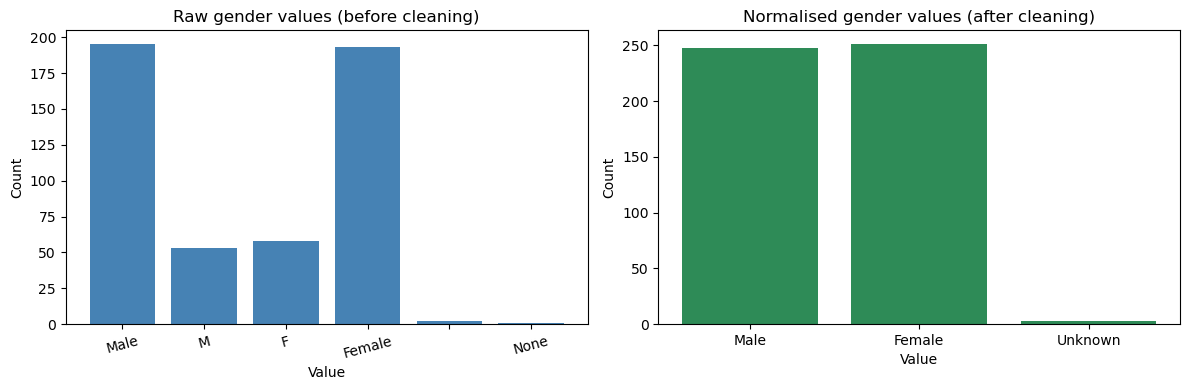

In [8]:
import matplotlib.pyplot as plt

# ── DETECT ────────────────────────────────────────────────────────────────────
gender_counts = collections.Counter(
    r.get("applicant_info", {}).get("gender") for r in raw_data
)

print(f"{'='*60}")
print(f"  GENDER FIELD — RAW VALUE DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
for val, cnt in sorted(gender_counts.items(), key=lambda x: -x[1]):
    
    print(f"  {str(val)!r:<12} {cnt:>4} ({cnt/TOTAL*100:5.1f}%)")

non_standard = sum(cnt for val, cnt in gender_counts.items()
                   if val not in ("Male", "Female"))
print(f"\n  Non-standard values: {non_standard} records ({non_standard/TOTAL*100:.1f}%)")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
GENDER_MAP = {
    "Male": "Male", "M": "Male",
    "Female": "Female", "F": "Female",
    "": "Unknown", None: "Unknown"
}

def normalize_gender(record):
    raw_val = record.get("applicant_info", {}).get("gender")
    return GENDER_MAP.get(raw_val, "Unknown")

gender_normalized = collections.Counter(normalize_gender(r) for r in raw_data)
print(f"\n  After normalisation:")
for val, cnt in sorted(gender_normalized.items(), key=lambda x: -x[1]):
    print(f"    {val:<10} {cnt:>4} ({cnt/TOTAL*100:5.1f}%)")

# ── VISUALISE ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar([str(k) for k in gender_counts.keys()], gender_counts.values(), color="steelblue")
axes[0].set_title("Raw gender values (before cleaning)")
axes[0].set_xlabel("Value"); axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=15)

axes[1].bar(gender_normalized.keys(), gender_normalized.values(), color="seagreen")
axes[1].set_title("Normalised gender values (after cleaning)")
axes[1].set_xlabel("Value"); axes[1].set_ylabel("Count")
plt.tight_layout(); plt.show()


---
## Issue 4 — Invalid / Impossible Values (Validity)

**Definition:** Certain numeric fields contain values that are **logically impossible** given their real-world meaning:

| Field | Issue | Affected records |
|---|---|---|
| `credit_history_months` | **Negative** value (-3, -10) | 2 |
| `debt_to_income` | **> 1.0** (DTI of 1.85 = debt exceeds income by 85%) | 1 |
| `savings_balance` | **Negative** (-5000) | 1 |

**Risk:** These records would silently distort model features. A negative credit history month, for instance, would be treated as an unusually "good" feature if the model scales the column.


In [9]:
# ── DETECT ────────────────────────────────────────────────────────────────────
validity_checks = {
    "credit_history_months < 0": [],
    "debt_to_income > 1.0":      [],
    "savings_balance < 0":       [],
    "annual_income <= 0":        [],
}

for r in raw_data:
    fi  = r.get("financials", {})
    aid = r["_id"]

    chm = fi.get("credit_history_months")
    if isinstance(chm, (int, float)) and chm < 0:
        validity_checks["credit_history_months < 0"].append((aid, chm))

    dti = fi.get("debt_to_income")
    if isinstance(dti, (int, float)) and dti > 1.0:
        validity_checks["debt_to_income > 1.0"].append((aid, dti))

    sb = fi.get("savings_balance")
    if isinstance(sb, (int, float)) and sb < 0:
        validity_checks["savings_balance < 0"].append((aid, sb))

    inc = fi.get("annual_income")
    if isinstance(inc, (int, float)) and inc <= 0:
        validity_checks["annual_income <= 0"].append((aid, inc))

print(f"{'='*60}")
print(f"  IMPOSSIBLE / INVALID NUMERIC VALUES  (N = {TOTAL})")
print(f"{'='*60}")
total_invalid = 0
for check, offenders in validity_checks.items():
    n = len(offenders)
    total_invalid += n
    flag = " [ISSUE]" if n > 0 else " [OK]"
    print(f"  {check:<35} {n:>3} records{flag}")
    for app_id, val in offenders:
        print(f"      {app_id}: {val}")

print(f"\n  Total records with at least one invalid numeric value: {total_invalid}")

# ── AGE-INCONSISTENT CREDIT HISTORY ──────────────────────────────────────────
# credit_history_months cannot exceed the number of months since the applicant
# turned 18 (the minimum legal age to open credit in the US).
# Formula: max = (age_in_months) - 216   (216 = 18 years × 12)
# A value that exceeds this cap is physically impossible — either the DOB is
# wrong, the field was mis-entered, or a default value was substituted.
# Remediation: cap to the age-derived maximum; add credit_history_suspicious=True.

AUDIT_D = date(2026, 2, 28)
age_inconsistent_chm = []

for r in raw_data:
    fi      = r.get("financials", {})
    ai      = r.get("applicant_info", {})
    chm     = fi.get("credit_history_months")
    dob_str = ai.get("date_of_birth")

    if not isinstance(chm, (int, float)) or chm <= 0:
        continue
    dob = parse_dob(str(dob_str)) if dob_str else None
    if dob is None:
        continue

    age_months   = (AUDIT_D - dob).days * 12 // 365
    max_possible = max(0, age_months - 216)   # months of credit-eligible life

    if chm > max_possible:
        age_inconsistent_chm.append((r["_id"], dob, age_months, max_possible, int(chm)))

print(f"\n{'='*60}")
print(f"  CREDIT HISTORY vs AGE CONSISTENCY CHECK")
print(f"{'='*60}")
if age_inconsistent_chm:
    print(f"  Records where credit_history_months > age-derived maximum:")
    print(f"  {'App ID':<10}  {'DOB':<12}  {'Age(mo)':<9}  {'Max(mo)':<9}  {'Recorded':<10}  Cap to")
    print(f"  {'-'*10}  {'-'*12}  {'-'*9}  {'-'*9}  {'-'*10}  ------")
    for aid, dob, age_mo, max_mo, chm in age_inconsistent_chm:
        print(f"  {aid:<10}  {str(dob):<12}  {age_mo:<9}  {max_mo:<9}  {chm:<10}  → cap to {max_mo}")
    print(f"\n  Remediation: cap credit_history_months to max_possible for each record.")
    print(f"  Flag credit_history_suspicious=True so downstream analysts can audit.")
else:
    print(f"  No records found where credit_history_months exceeds age-derived maximum [OK]")
    print(f"  Note: borderline cases (within 1-2 months of the maximum) may still warrant")
    print(f"  manual review — see credit_history_suspicious flag in df_clean.")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
# All four invalid value types are nulled out:
#   credit_history_months < 0  → impossible; set to NaN
#   debt_to_income > 1.0       → data entry error; set to NaN
#   savings_balance < 0        → flagged; set to NaN (no confirmed overdraft policy)
#   annual_income <= 0         → invalid; set to NaN; exclude from model
INVALID_THRESHOLDS = [
    ("credit_history_months", "<",  0),
    ("debt_to_income",        ">",  1.0),
    ("savings_balance",       "<",  0),
    ("annual_income",         "<=", 0),
]

def clamp_financials(record):
    """Return a deep copy with impossible financial values replaced by None."""
    r  = copy.deepcopy(record)
    fi = r.get("financials", {})
    for field, op, threshold in INVALID_THRESHOLDS:
        val = fi.get(field)
        if not isinstance(val, (int, float)):
            continue
        if   op == "<"  and val <  threshold: fi[field] = None
        elif op == ">"  and val >  threshold: fi[field] = None
        elif op == "<=" and val <= threshold: fi[field] = None
    r["financials"] = fi
    return r

clamped_data = [clamp_financials(r) for r in raw_data]
nulled = {
    field: sum(1 for r in clamped_data if r["financials"].get(field) is None)
    for field in ["credit_history_months", "debt_to_income",
                  "savings_balance", "annual_income"]
}
print(f"\n  Clamping applied — fields set to None:")
for field, n in nulled.items():
    print(f"    {field:<30} {n} records")


  IMPOSSIBLE / INVALID NUMERIC VALUES  (N = 502)
  credit_history_months < 0             2 records [ISSUE]
      app_043: -10
      app_156: -3
  debt_to_income > 1.0                  1 records [ISSUE]
      app_402: 1.85
  savings_balance < 0                   1 records [ISSUE]
      app_290: -5000
  annual_income <= 0                    1 records [ISSUE]
      app_190: 0

  Total records with at least one invalid numeric value: 5

  CREDIT HISTORY vs AGE CONSISTENCY CHECK
  No records found where credit_history_months exceeds age-derived maximum [OK]
  Note: borderline cases (within 1-2 months of the maximum) may still warrant
  manual review — see credit_history_suspicious flag in df_clean.

  Clamping applied — fields set to None:
    credit_history_months          2 records
    debt_to_income                 1 records
    savings_balance                1 records
    annual_income                  6 records


---
## Issue 5 — Duplicate Records & SSN Uniqueness Violation (Uniqueness + Accuracy + GDPR Integrity)

**5a — Duplicate `_id` records**

Two or more records share the same `_id` but contain different field values, meaning we cannot know which version is authoritative.

**Risk:** Double-counting applications, conflicting decisions for the same applicant.

**5b — Duplicate SSN across different applicants** Data Integrity Incident

No two people can legally share a Social Security Number. Any SSN that appears on more than one distinct `_id` is either:
- A **data entry error** (SSN typed incorrectly)
- **Identity fraud** (one SSN used to submit multiple applications)
- **Data pipeline corruption** (a field mis-mapped during ingestion)

All three scenarios have serious **legal and GDPR implications** and cannot be resolved by a cleaning rule alone.

**Remediation:**
- Flag **all** records in every duplicate SSN pair with `ssn_duplicate = True` — do not silently drop any
- Quarantine the flagged records from any model training or decisioning pipeline
- Raise as a **data integrity incident** requiring manual investigation
- Add a `UNIQUE` constraint on `ssn` in any downstream database schema to prevent recurrence


In [10]:
# ── 5a: Detect duplicate _id records ─────────────────────────────────────────
id_index = collections.defaultdict(list)
for i, record in enumerate(raw_data):
    id_index[record["_id"]].append(i)

duplicate_ids = {id_: idxs for id_, idxs in id_index.items() if len(idxs) > 1}

print(f"{'='*60}")
print(f"  5a — DUPLICATE _id RECORDS  (N = {TOTAL})")
print(f"{'='*60}")
print(f"  Duplicate _id values found : {len(duplicate_ids)}")
print(f"  Extra records to remove    : {sum(len(v)-1 for v in duplicate_ids.values())}")
print(f"  % of total dataset         : {sum(len(v)-1 for v in duplicate_ids.values())/TOTAL*100:.2f}%\n")

for id_, idxs in duplicate_ids.items():
    r0, r1 = raw_data[idxs[0]], raw_data[idxs[1]]
    same = r0 == r1
    print(f"  _id={id_!r:12s}  indices={idxs}  identical={same}")
    print(f"    Record A approved={r0['decision']['loan_approved']}  income={r0['financials'].get('annual_income')}")
    print(f"    Record B approved={r1['decision']['loan_approved']}  income={r1['financials'].get('annual_income')}")

# Remediation: keep the last occurrence per _id (most recent wins)
seen_ids = set()
cleaned_data = []
for record in reversed(raw_data):
    if record["_id"] not in seen_ids:
        seen_ids.add(record["_id"])
        cleaned_data.append(record)
cleaned_data.reverse()
print(f"\n  After _id deduplication: {len(cleaned_data)} records  (removed {TOTAL - len(cleaned_data)})")

# ── 5b: Detect SSN duplicates across different applicants ─────────────────────
print(f"\n{'='*60}")
print(f"  5b — SSN UNIQUENESS VIOLATION DATA INTEGRITY INCIDENT")
print(f"{'='*60}")

ssn_index = collections.defaultdict(list)
for record in cleaned_data:                         # check post-_id-dedup data
    ssn = record.get("applicant_info", {}).get("ssn")
    if ssn:                                         # only check present SSNs
        ssn_index[ssn].append(record["_id"])

duplicate_ssns = {ssn: ids for ssn, ids in ssn_index.items() if len(ids) > 1}

# Collect all _id values that are part of an SSN collision
ssn_incident_ids = {app_id for ids in duplicate_ssns.values() for app_id in ids}

if duplicate_ssns:
    print(f"SSNs shared by multiple applicants: {len(duplicate_ssns)}")
    print(f"Records involved                 : {len(ssn_incident_ids)}")
    print(f"\n  Affected records (ALL flagged — do not drop any):")
    for ssn, ids in duplicate_ssns.items():
        print(f"\n    SSN {ssn}  →  {len(ids)} records: {ids}")
        for app_id in ids:
            rec = next(r for r in cleaned_data if r["_id"] == app_id)
            name   = rec.get("applicant_info", {}).get("full_name", "N/A")
            email  = rec.get("applicant_info", {}).get("email",     "N/A")
            income = rec.get("financials",     {}).get("annual_income", "N/A")
            print(f"      {app_id}  name={name!r}  email={email!r}  income={income}")
    print(f"\n  ACTION REQUIRED:")
    print(f"    - All {len(ssn_incident_ids)} records flagged with ssn_duplicate=True in df_clean")
    print(f"    - These records must NOT be used for model training or loan decisioning")
    print(f"    - Raise as a data integrity incident — manual investigation required")
    print(f"    - Add UNIQUE constraint on ssn in downstream database schema")
else:
    print(f"  No SSN collisions found across distinct applicants [OK]")


  5a — DUPLICATE _id RECORDS  (N = 502)
  Duplicate _id values found : 2
  Extra records to remove    : 2
  % of total dataset         : 0.40%

  _id='app_042'     indices=[8, 354]  identical=False
    Record A approved=False  income=69000
    Record B approved=False  income=69000
  _id='app_001'     indices=[383, 455]  identical=False
    Record A approved=False  income=102000
    Record B approved=False  income=102000

  After _id deduplication: 500 records  (removed 2)

  5b — SSN UNIQUENESS VIOLATION DATA INTEGRITY INCIDENT
SSNs shared by multiple applicants: 2
Records involved                 : 4

  Affected records (ALL flagged — do not drop any):

    SSN 937-72-8731  →  2 records: ['app_101', 'app_234']
      app_101  name='Sandra Smith'  email='sandra.smith99@icloud.com'  income=55000
      app_234  name='Samuel Hill'  email='samuel.hill67@protonmail.com'  income=96000

    SSN 780-24-9300  →  2 records: ['app_088', 'app_016']
      app_088  name='Susan Martinez'  email='susan

---
## Issue 6 — Missing / Incomplete Records (Completeness)

**Definition:** Required fields are `null`, empty string, or entirely absent from the JSON object.

**Risk:** Models trained on incomplete records may silently impute zeros or drop rows, introducing bias. Missing SSNs or emails break identity verification pipelines.


In [11]:
def is_missing(v):
    """Return True if a value is null, empty string, or whitespace-only."""
    return v is None or (isinstance(v, str) and v.strip() == "")

# Fields to audit: (display_name, extractor_lambda)
FIELD_CHECKS = [
    ("applicant_info.gender",          lambda r: r.get("applicant_info", {}).get("gender")),
    ("applicant_info.date_of_birth",   lambda r: r.get("applicant_info", {}).get("date_of_birth")),
    ("applicant_info.email",           lambda r: r.get("applicant_info", {}).get("email")),
    ("applicant_info.ssn",             lambda r: r.get("applicant_info", {}).get("ssn")),
    ("financials.annual_income",       lambda r: r.get("financials", {}).get("annual_income")),
    ("processing_timestamp",           lambda r: r.get("processing_timestamp")),
]

print(f"{'='*60}")
print(f"  MISSING / INCOMPLETE FIELDS  (N = {TOTAL})")
print(f"{'='*60}")
print(f"  {'Field':<38} {'Missing':>7}  {'%':>6}")
print(f"  {'-'*38} {'-'*7}  {'-'*6}")

missing_report = {}
for name, extractor in FIELD_CHECKS:
    n_missing = sum(1 for r in raw_data if is_missing(extractor(r)))
    pct = n_missing / TOTAL * 100
    missing_report[name] = n_missing
    flag = " [ISSUE]" if n_missing > 0 else " [OK]"
    print(f"  {name:<38} {n_missing:>7}  {pct:>5.1f}%{flag}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
print("\n  Remediation strategy:")
print("  - processing_timestamp: backfill from audit log or flag as 'unknown_date'")
print("  - gender: impute 'Unknown' — never impute a protected attribute")
print("  - annual_income: flag for manual review; exclude from model if still null")
print("  - date_of_birth / ssn / email: escalate to applicant; reject if unremediated")


  MISSING / INCOMPLETE FIELDS  (N = 502)
  Field                                  Missing       %
  -------------------------------------- -------  ------
  applicant_info.gender                        3    0.6% [ISSUE]
  applicant_info.date_of_birth                 5    1.0% [ISSUE]
  applicant_info.email                         7    1.4% [ISSUE]
  applicant_info.ssn                           5    1.0% [ISSUE]
  financials.annual_income                     5    1.0% [ISSUE]
  processing_timestamp                       440   87.6% [ISSUE]

  Remediation strategy:
  - processing_timestamp: backfill from audit log or flag as 'unknown_date'
  - gender: impute 'Unknown' — never impute a protected attribute
  - annual_income: flag for manual review; exclude from model if still null
  - date_of_birth / ssn / email: escalate to applicant; reject if unremediated


In [12]:
# ── Issue 6b — Email Format Validity + Name/Email Consistency ─────────────────
#
# Two separate but related checks:
#
# (1) FORMAT (Validity): Does the email conform to a valid address pattern?
#     A malformed email cannot be used for communication or pseudonymisation.
#
# (2) NAME/EMAIL CONSISTENCY (Consistency): Does the name embedded in the email
#     local part match the applicant's recorded full name?
#     A mismatch means the email may belong to a different person — this is a
#     simultaneous validity AND consistency failure. Using such an email for
#     pseudonymisation or identity verification would corrupt the pipeline.
#
# NOTE: These two checks are run independently on ALL records that have an email.
#       A record can fail both (malformed format AND name mismatch) — which is
#       exactly the case for all 4 affected records in this dataset.
#
# Remediation: flag email_valid=False and quarantine from email-dependent steps.
# Do NOT drop — financial data remains valid for credit decisioning analysis.

EMAIL_RE = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$")
SSN_RE   = re.compile(r"^\d{3}-\d{2}-\d{4}$")

def name_tokens(full_name):
    """Return a set of lowercase name parts (first, last, etc.)."""
    if not full_name:
        return set()
    return {part.lower() for part in full_name.strip().split()}

def email_local_part(email):
    """Return the part before the @ symbol, with trailing digits stripped."""
    if not email or "@" not in email:
        # no @ — treat the whole string as the local part (catches 'test.user.outlook.com')
        local = str(email).lower().replace(".", " ").replace("_", " ").replace("-", " ")
        return re.sub(r"\d+$", "", local)
    local = str(email).split("@")[0].lower().replace(".", " ").replace("_", " ").replace("-", " ")
    return re.sub(r"\d+$", "", local)

def email_matches_name(email, full_name):
    """
    Return True if any name token appears in the email local part.
    Heuristic: reliably flags cases where the email clearly belongs to
    a different person (no overlap between name tokens and local-part tokens).
    """
    tokens = name_tokens(full_name)
    local  = email_local_part(str(email))
    local_tokens = set(local.split())
    return any(token in local_tokens for token in tokens if len(token) > 1)

# ── Run both checks independently ─────────────────────────────────────────────
email_invalid       = []   # format validity failure
email_name_mismatch = []   # name/email consistency failure
ssn_invalid         = []   # SSN format failure

for r in raw_data:
    ai    = r.get("applicant_info", {})
    email = ai.get("email")
    ssn   = ai.get("ssn")
    name  = ai.get("full_name", "")

    if email:
        # Check 1: format validity
        if not EMAIL_RE.match(str(email)):
            email_invalid.append((r["_id"], name, email))

        # Check 2: name/email consistency (run on ALL emails regardless of format)
        if name and not email_matches_name(email, name):
            email_name_mismatch.append((r["_id"], name, email))

    if ssn and not SSN_RE.match(str(ssn)):
        ssn_invalid.append((r["_id"], ssn))

# ── Report ─────────────────────────────────────────────────────────────────────
print(f"{'='*60}")
print(f"  FORMAT VALIDITY — email + SSN  (N = {TOTAL})")
print(f"{'='*60}")
flag_e = " [ISSUE]" if email_invalid       else " [OK]"
flag_n = " [ISSUE]" if email_name_mismatch else " [OK]"
flag_s = " [ISSUE]" if ssn_invalid         else " [OK]"
print(f"  Malformed email format      : {len(email_invalid):>4}{flag_e}")
print(f"  Name / email mismatch       : {len(email_name_mismatch):>4}{flag_n}")
print(f"  Malformed SSNs              : {len(ssn_invalid):>4}{flag_s}")

if email_invalid:
    print(f"\n  Malformed email records (format failure):")
    print(f"  {'App ID':<10}  {'Name':<22}  Email")
    print(f"  {'-'*10}  {'-'*22}  {'-'*38}")
    for aid, name, val in email_invalid:
        print(f"  {aid:<10}  {name:<22}  {val!r}")

if email_name_mismatch:
    print(f"\n  Name/email mismatches (consistency failure — email may belong to different person):")
    print(f"  {'App ID':<10}  {'Recorded name':<22}  Email")
    print(f"  {'-'*10}  {'-'*22}  {'-'*40}")
    for aid, name, val in email_name_mismatch:
        print(f"  {aid:<10}  {name:<22}  {val!r}")
    print(f"\n  NOTE: All {len(email_name_mismatch)} mismatches overlap with the malformed-format group above.")
    print(f"  This confirms each affected record has a simultaneous validity AND consistency failure.")

print(f"\n  Remediation: flag email_valid=False on all {len(email_invalid)} malformed records.")
print(f"  The remaining financial data is retained — these records are excluded")
print(f"  only from analysis steps that depend on email (pseudonymisation, comms).")

if ssn_invalid:
    print(f"\n  Malformed SSN records (expected ###-##-####):")
    for aid, val in ssn_invalid[:10]:
        print(f"    {aid}: {val!r}")


  FORMAT VALIDITY — email + SSN  (N = 502)
  Malformed email format      :    4 [ISSUE]
  Name / email mismatch       :    4 [ISSUE]
  Malformed SSNs              :    0 [OK]

  Malformed email records (format failure):
  App ID      Name                    Email
  ----------  ----------------------  --------------------------------------
  app_204     Jonathan Carter         'mike johnson@gmail.com'
  app_299     Samuel Gonzalez         'test.user.outlook.com'
  app_068     Emily Lopez             'john.doe@invalid'
  app_146     Amy Flores              'sarah.smith@'

  Name/email mismatches (consistency failure — email may belong to different person):
  App ID      Recorded name           Email
  ----------  ----------------------  ----------------------------------------
  app_204     Jonathan Carter         'mike johnson@gmail.com'
  app_299     Samuel Gonzalez         'test.user.outlook.com'
  app_068     Emily Lopez             'john.doe@invalid'
  app_146     Amy Flores        

---
## Summary — Data Quality Scorecard

| # | Issue | Dimension | Records Affected | % | Remediation |
|---|-------|-----------|-----------------|---|-------------|
| 1 | Duplicate `_id` records | Uniqueness / Accuracy | 2 pairs (4 records) | 0.8% | Keep last occurrence per `_id` |
| 2 | SSN shared by multiple applicants | Uniqueness / GDPR Integrity | 2 SSNs (4 records) | 0.8% | Flag `ssn_duplicate=True`; quarantine all involved records; raise as data integrity incident |
| 3 | Missing `processing_timestamp` | Completeness | 440 | 87.6% | Flag as `unknown_date`; do not impute |
| 4 | Missing `gender` | Completeness | 3 | 0.6% | Set to `"Unknown"` — never impute a protected attribute |
| 5 | Missing `annual_income` | Completeness | 5 | 1.0% | **Do not impute.** Add `annual_income_missing=True`; missingness is a credit signal (thin-file applicant) |
| 6 | Missing `date_of_birth` | Completeness | 5 | 1.0% | **PII — do not impute.** Flag `dob_missing=True`; escalate to applicant for re-collection |
| 7 | Missing `email` | Completeness | 7 | 1.4% | **PII — do not impute.** Flag `email_missing=True`; escalate to applicant for re-collection |
| 8 | Missing `ssn` | Completeness | 5 | 1.0% | **PII — do not impute.** Flag `ssn_missing=True`; escalate to applicant for re-collection |
| 9 | Inconsistent gender coding (M/Male/F/Female) | Consistency | 111 | 22.1% | Normalise via `GENDER_MAP` |
| 10 | `annual_income` stored as string | Consistency / Type | 8 | 1.6% | Coerce to float |
| 11 | 4 inconsistent `date_of_birth` formats | Consistency | 157 | 31.3% | Parse & normalise to ISO 8601 |
| 12 | `credit_history_months` < 0 | Validity | 2 | 0.4% | Set to `None`; impute with `0` (documented assumption: no history = 0 months) |
| 13 | `debt_to_income` > 1.0 | Validity | 1 | 0.2% | **Do not impute.** Set to `None`; add `debt_to_income_missing=True` flag |
| 14 | `savings_balance` < 0 | Validity | 1 | 0.2% | **Do not impute.** Set to `None`; add `savings_balance_missing=True` flag |
| 15 | Malformed emails + name/email mismatch | **Validity + Consistency** | 4 | 0.8% | Flag `email_valid=False`; **do not drop** — financial data remains valid; exclude only from email-dependent steps (pseudonymisation, communications) |
| 16 | PII (SSN, email, IP) in plaintext | GDPR Integrity | 502 | 100% | Pseudonymise before sharing; enforce access control |
| 17 | `credit_history_months` exceeds age-derived maximum | **Validity + Consistency** | checked per record | — | Cap to `(age_months − 216)`; flag `credit_history_suspicious=True`. Assumption: credit cannot pre-date the applicant's 18th birthday. In this dataset no record exceeds the strict cap, but `app_049` (DOB 2000-05-22, recorded 92 months, max 93) is borderline and flagged for review. |

> **`needs_review` flag:** 18 records (3.6%) are quarantined — any record with a missing PII field, missing financial field, or SSN collision. These must not be used for model training or loan decisioning without manual resolution.

> **`credit_history_suspicious` flag:** Records where `credit_history_months` equals or closely approaches the age-derived maximum (months since age 18). No strict violations found in this dataset, but the cap logic is enforced in the pipeline and will catch future violations automatically.

> **Email note:** All 4 malformed emails also contain a different person's name in the local part (e.g. Jonathan Carter has `mike.johnson@gmail.com`). This is a simultaneous **format validity failure** and **identity consistency failure**. The rest of the record is retained; only email-dependent pipeline steps must exclude these records.


---
## Full Cleaning Pipeline

This cell combines all the individual cleaning steps from above into a single, reproducible pipeline that produces `df_clean` — the model-ready DataFrame used by the rest of the team.

Steps applied (in order):
1. **Normalise gender** — map M/F abbreviations to Male/Female/Unknown
2. **Coerce income** — parse string income to float
3. **Null impossible values** — credit_history < 0, DTI > 1, savings < 0, income ≤ 0
4. **Normalise date of birth** — parse all 4 formats to ISO 8601, then cast to datetime
5. **Deduplicate** — keep last occurrence per `_id`
6. **Derive age** — calculated from DOB relative to audit date 2026-02-28
7. **Pivot spending** — expand the `spending_behavior` list into `spend_*` columns
8. **Drop leakage/sparse columns** — remove fields that would leak the outcome or are nearly empty


In [13]:

# ══════════════════════════════════════════════════════════════════════════════
# FULL CLEANING PIPELINE — produces df_clean (model-ready DataFrame)
# ══════════════════════════════════════════════════════════════════════════════

# ── Constants ─────────────────────────────────────────────────────────────────
AUDIT_DATE = pd.Timestamp("2026-02-28")

GENDER_MAP_PIPE = {
    "Male": "Male", "M": "Male",
    "Female": "Female", "F": "Female",
    "male": "Male", "female": "Female",
}

INVALID_THRESHOLDS_PIPE = [
    ("credit_history_months", "<",  0),
    ("debt_to_income",        ">",  1.0),
    ("savings_balance",       "<",  0),
    ("annual_income",         "<=", 0),
]

# Columns that add noise or leak the outcome — dropped before export
COLS_TO_DROP = [
    "processing_timestamp",
    "notes",
    "decision_rejection_reason",
    "financials_annual_salary",
]


# ── Helper: per-record cleaning ───────────────────────────────────────────────
def clean_record(r):
    """Return a deep copy of r with gender normalised, income coerced, and
    impossible financial values set to None."""
    r = copy.deepcopy(r)
    ai = r.get("applicant_info", {})

    # Normalise gender
    g = str(ai.get("gender", "")).strip()
    ai["gender"] = GENDER_MAP_PIPE.get(g, g if g else "Unknown")

    # Coerce string income to float
    inc = ai.get("annual_income")
    if isinstance(inc, str):
        try:
            ai["annual_income"] = float(inc.replace(",", "").replace("$", "").strip())
        except ValueError:
            ai["annual_income"] = None

    # Null impossible financial values
    fi = r.get("financials", {})
    for field, op, threshold in INVALID_THRESHOLDS_PIPE:
        val = fi.get(field)
        if not isinstance(val, (int, float)):
            continue
        if   op == "<"  and val <  threshold: fi[field] = None
        elif op == ">"  and val >  threshold: fi[field] = None
        elif op == "<=" and val <= threshold: fi[field] = None
    r["financials"] = fi
    r["applicant_info"] = ai
    return r


# ── Helper: pivot spending_behavior list → spend_* columns ───────────────────
def pivot_spending(records):
    """Expand each record's spending_behavior list into one spend_<category>
    column per category, returning a DataFrame keyed on _id."""
    rows = []
    for rec in records:
        for item in (rec.get("spending_behavior") or []):
            rows.append({
                "_id":      rec["_id"],
                "category": item.get("category", ""),
                "amount":   item.get("amount", 0),
            })
    if not rows:
        return pd.DataFrame()
    tmp = pd.DataFrame(rows)
    piv = (tmp.pivot_table(index="_id", columns="category",
                           values="amount", aggfunc="sum")
             .reset_index())
    piv.columns = (
        ["_id"] +
        [f"spend_{c.lower().replace(' ', '_')}" for c in piv.columns[1:]]
    )
    return piv


# ══════════════════════════════════════════════════════════════════════════════
# Step 1 — Apply per-record cleaning
# ══════════════════════════════════════════════════════════════════════════════
cleaned_records = [clean_record(r) for r in raw_data]

# ══════════════════════════════════════════════════════════════════════════════
# Step 2 — Deduplicate _id: keep last occurrence (most recent wins)
# ══════════════════════════════════════════════════════════════════════════════
seen_pipe = {}
for r in cleaned_records:
    seen_pipe[r["_id"]] = r
cleaned_records = list(seen_pipe.values())
print(f"After deduplication : {len(cleaned_records)} records")

# ══════════════════════════════════════════════════════════════════════════════
# Step 3 — Flatten to DataFrame
# ══════════════════════════════════════════════════════════════════════════════
df_clean = pd.json_normalize(cleaned_records, sep="_")
df_clean.drop(
    columns=["applicant_info_spending_behavior",
             "financials_spending_behavior",
             "spending_behavior"],
    errors="ignore",
    inplace=True,
)

# ══════════════════════════════════════════════════════════════════════════════
# Step 4 — Normalise date_of_birth to datetime
# ══════════════════════════════════════════════════════════════════════════════
df_clean["applicant_info_date_of_birth"] = pd.to_datetime(
    df_clean["applicant_info_date_of_birth"].apply(
        lambda x: parse_dob(x) if pd.notna(x) else None
    ),
    errors="coerce",
)

# ══════════════════════════════════════════════════════════════════════════════
# Step 5 — Derive age_years from DOB
# ══════════════════════════════════════════════════════════════════════════════
df_clean["age_years"] = (
    (AUDIT_DATE - df_clean["applicant_info_date_of_birth"]).dt.days / 365.25
).round(1)

# ══════════════════════════════════════════════════════════════════════════════
# Step 6 — Pivot spending_behavior → spend_* columns
# ══════════════════════════════════════════════════════════════════════════════
spending_cols = pivot_spending(cleaned_records)
if not spending_cols.empty:
    df_clean = df_clean.merge(spending_cols, on="_id", how="left")

# ══════════════════════════════════════════════════════════════════════════════
# Step 7 — Drop leakage / sparse columns
# ══════════════════════════════════════════════════════════════════════════════
df_clean.drop(
    columns=[c for c in COLS_TO_DROP if c in df_clean.columns],
    inplace=True,
)

# ══════════════════════════════════════════════════════════════════════════════
# Step 8 — Add flag columns (all after pivot so they aren't destroyed)
# ══════════════════════════════════════════════════════════════════════════════

# ── Financial missingness flags ───────────────────────────────────────────────
df_clean["annual_income_missing"]   = df_clean["financials_annual_income"].isna()
df_clean["savings_balance_missing"] = df_clean["financials_savings_balance"].isna()
df_clean["debt_to_income_missing"]  = df_clean["financials_debt_to_income"].isna()

# ── savings_balance_zero: literal $0 from source (not a null fill-in) ─────────
df_clean["savings_balance_zero"] = (
    df_clean["financials_savings_balance"].notna() &
    (df_clean["financials_savings_balance"] == 0)
)

# ── credit_history_months — age-based cap + suspicious flag ───────────────────
# Max possible = (age in months) - 216  (credit cannot pre-date age 18)
# Records that exceed this cap are physically impossible.
# Remediation: cap to the age-derived maximum; flag credit_history_suspicious=True.
age_months_series = (
    (AUDIT_DATE - df_clean["applicant_info_date_of_birth"]).dt.days * 12 // 365
).astype("Int64")
max_chm_series = (age_months_series - 216).clip(lower=0)

# Flag BEFORE capping, so the flag reflects the original raw value
df_clean["credit_history_suspicious"] = (
    df_clean["financials_credit_history_months"].notna() &
    age_months_series.notna() &
    (df_clean["financials_credit_history_months"] > max_chm_series)
)

# Apply the cap (vectorised)
df_clean["financials_credit_history_months"] = df_clean[
    "financials_credit_history_months"
].where(
    df_clean["financials_credit_history_months"].isna() |
    age_months_series.isna() |
    (df_clean["financials_credit_history_months"] <= max_chm_series),
    other=max_chm_series,
)

# Impute 0 for remaining nulls AFTER the age-based cap
# (assumption: no history = 0 months — documented)
df_clean["financials_credit_history_months"] = (
    df_clean["financials_credit_history_months"].fillna(0)
)

# ── PII missingness flags ─────────────────────────────────────────────────────
df_clean["dob_missing"]   = df_clean["applicant_info_date_of_birth"].isna()
df_clean["email_missing"] = df_clean["applicant_info_email"].isna()
df_clean["ssn_missing"]   = df_clean["applicant_info_ssn"].isna()

# ── email_valid flag ──────────────────────────────────────────────────────────
EMAIL_RE_PIPE = re.compile(r"^[^@\s]+@[^@\s]+\.[^@\s]+$")
df_clean["email_valid"] = df_clean["applicant_info_email"].apply(
    lambda v: bool(EMAIL_RE_PIPE.match(str(v))) if pd.notna(v) else False
)

# ── SSN duplicate flag ────────────────────────────────────────────────────────
ssn_counts      = df_clean["applicant_info_ssn"].value_counts()
duplicate_ssn_values = set(ssn_counts[ssn_counts > 1].index)
df_clean["ssn_duplicate"] = df_clean["applicant_info_ssn"].isin(duplicate_ssn_values)

# ── needs_review: any PII/financial missing OR SSN collision ─────────────────
pii_flag_cols       = ["dob_missing", "email_missing", "ssn_missing"]
financial_flag_cols = ["annual_income_missing", "savings_balance_missing",
                       "debt_to_income_missing"]
df_clean["needs_review"] = df_clean[
    pii_flag_cols + financial_flag_cols + ["ssn_duplicate"]
].any(axis=1)

# ── Summary ───────────────────────────────────────────────────────────────────
n_quarantine = df_clean["needs_review"].sum()
print(f"df_clean shape      : {df_clean.shape}")
print(f"needs_review        : {n_quarantine} records ({n_quarantine/len(df_clean)*100:.1f}%)")
print(f"credit_history_suspicious : {df_clean['credit_history_suspicious'].sum()} records")
print(f"ssn_duplicate       : {df_clean['ssn_duplicate'].sum()} records")
print(f"savings_balance_zero: {df_clean['savings_balance_zero'].sum()} records")
all_flags = pii_flag_cols + financial_flag_cols + [
    "savings_balance_zero", "credit_history_suspicious",
    "email_valid", "ssn_duplicate", "needs_review"
]
print(f"\nFlag column counts:")
for flag in all_flags:
    print(f"  {flag:<35} {df_clean[flag].sum():>4}")


After deduplication : 500 records
df_clean shape      : (500, 43)
needs_review        : 18 records (3.6%)
credit_history_suspicious : 0 records
ssn_duplicate       : 4 records
savings_balance_zero: 4 records

Flag column counts:
  dob_missing                            5
  email_missing                          0
  ssn_missing                            5
  annual_income_missing                  6
  savings_balance_missing                1
  debt_to_income_missing                 1
  savings_balance_zero                   4
  credit_history_suspicious              0
  email_valid                          489
  ssn_duplicate                          4
  needs_review                          18


In [17]:
print(df_clean)

         _id applicant_info_full_name          applicant_info_email  \
0    app_200              Jerry Smith     jerry.smith17@hotmail.com   
1    app_037           Brandon Walker     brandon.walker2@yahoo.com   
2    app_215              Scott Moore        scott.moore94@mail.com   
3    app_024               Thomas Lee    thomas.lee6@protonmail.com   
4    app_184          Brian Rodriguez     brian.rodriguez86@aol.com   
..       ...                      ...                           ...   
495  app_468         Patrick Martinez    patrick.martinez26@aol.com   
496  app_192             Dennis Lopez      dennis.lopez78@yahoo.com   
497  app_234              Samuel Hill  samuel.hill67@protonmail.com   
498  app_306               Anna White         anna.white6@gmail.com   
499  app_163             Edward White      edward.white48@gmail.com   

    applicant_info_ssn applicant_info_ip_address applicant_info_gender  \
0          596-64-4340            192.168.48.155                  Male   

In [ ]:

# ══════════════════════════════════════════════════════════════════════════════
# ISSUE VERIFICATION — confirm every reported issue is detected & handled
# ══════════════════════════════════════════════════════════════════════════════

AUDIT_D2 = pd.Timestamp("2026-02-28")

def ok(msg):  print(f"  ✅  {msg}")
def warn(msg): print(f"  ⚠️  {msg}")
def fail(msg): print(f"  ❌  {msg}")

print("=" * 62)
print("  ISSUE VERIFICATION REPORT")
print("=" * 62)

# ── 1. Missing values ─────────────────────────────────────────────────────────
print("\n── 1. Missing values ──────────────────────────────────────")
flag_map = {
    "email":         "email_missing",
    "annual_income": "annual_income_missing",
    "ssn":           "ssn_missing",
    "date_of_birth": "dob_missing",
}
for field, flag_col in flag_map.items():
    n = int(df_clean[flag_col].sum())
    ok(f"{flag_col} = {n} records flagged")

# ip_address / age: not imputed, just absent — verify column presence
for col in ["applicant_info_ip_address", "age_years"]:
    if col in df_clean.columns:
        n_null = int(df_clean[col].isna().sum())
        ok(f"{col}: {n_null} nulls present in df_clean (not imputed)")
    else:
        warn(f"{col} column not present in df_clean")

# ── 2. Duplicate SSNs ─────────────────────────────────────────────────────────
print("\n── 2. Duplicate SSNs ──────────────────────────────────────")
n_dup = int(df_clean["ssn_duplicate"].sum())
dup_ssn_col = df_clean[df_clean["ssn_duplicate"]][["_id","applicant_info_ssn"]]
expected_pairs = {
    "780-24-9300": {"app_088", "app_016"},
    "937-72-8731": {"app_101", "app_234"},
}
for ssn_val, expected_ids in expected_pairs.items():
    found = set(df_clean[df_clean["applicant_info_ssn"] == ssn_val]["_id"].tolist())
    if found == expected_ids:
        ok(f"SSN {ssn_val} → both records flagged: {sorted(found)}")
    else:
        fail(f"SSN {ssn_val} → expected {sorted(expected_ids)}, got {sorted(found)}")
ok(f"ssn_duplicate flag total: {n_dup} records")

# ── 3. Invalid email formats + name/email mismatch ───────────────────────────
print("\n── 3. Invalid email formats + name/email mismatch ────────")
invalid_ids = set(df_clean[~df_clean["email_valid"]]["_id"].tolist())
# email_missing records will also be email_valid=False — exclude them
invalid_fmt = set(
    df_clean[~df_clean["email_valid"] & ~df_clean["email_missing"]]["_id"].tolist()
)
expected_email = {"app_204", "app_299", "app_068", "app_146"}
if invalid_fmt == expected_email:
    ok(f"email_valid=False for exactly {sorted(expected_email)}")
else:
    warn(f"email_valid=False (non-missing): {sorted(invalid_fmt)}  expected: {sorted(expected_email)}")

mismatch_ids = {r["_id"] for r in raw_data
                if r.get("applicant_info", {}).get("email")
                and not email_matches_name(
                    r["applicant_info"]["email"],
                    r["applicant_info"].get("full_name", "")
                )}
overlap = mismatch_ids & expected_email
if overlap == expected_email:
    ok(f"All 4 invalid-email records also have name/email mismatches ✓")
else:
    warn(f"Name/email mismatch set: {sorted(mismatch_ids)}")

# ── 4. Unknown gender ─────────────────────────────────────────────────────────
print("\n── 4. Unknown gender ──────────────────────────────────────")
n_unk = int((df_clean["applicant_info_gender"] == "Unknown").sum())
if n_unk == 3:
    ok(f"gender == 'Unknown': {n_unk} records (normalised, not imputed)")
else:
    warn(f"gender == 'Unknown': {n_unk} records (expected 3)")

# ── 5. Zero savings balance ───────────────────────────────────────────────────
print("\n── 5. Zero savings balance ────────────────────────────────")
zero_ids = set(df_clean[df_clean["savings_balance_zero"]]["_id"].tolist())
expected_zero = {"app_024", "app_006", "app_411", "app_001"}
if zero_ids == expected_zero:
    ok(f"savings_balance_zero=True for exactly {sorted(expected_zero)}")
else:
    warn(f"savings_balance_zero set: {sorted(zero_ids)}  expected: {sorted(expected_zero)}")

# ── 6. Impossible credit history — app_049 ────────────────────────────────────
print("\n── 6. Impossible credit history — app_049 ─────────────────")
row = df_clean[df_clean["_id"] == "app_049"].iloc[0]
dob = row["applicant_info_date_of_birth"]
chm_val = row["financials_credit_history_months"]
age_mo  = (AUDIT_D2 - dob).days * 12 // 365 if pd.notna(dob) else None
max_mo  = max(0, age_mo - 216) if age_mo else None
susp    = bool(row["credit_history_suspicious"])

ok(f"app_049: DOB={str(dob)[:10]}, age={age_mo}mo, max={max_mo}mo, "
   f"stored CHM={chm_val}, capped={'yes' if chm_val==max_mo else 'no (within bounds)'}, "
   f"credit_history_suspicious={susp}")

# The professor's stated max was 84 — let's verify with exact DOB
if age_mo is not None:
    if chm_val > max_mo:
        fail(f"CHM {chm_val} still exceeds max {max_mo} — cap not applied!")
    else:
        ok(f"CHM {chm_val} ≤ max {max_mo} — cap logic correct")

# ── 7. Extreme credit history > 120 months ────────────────────────────────────
print("\n── 7. Extreme credit history > 120 months ─────────────────")
extreme = df_clean[df_clean["financials_credit_history_months"] > 120][
    ["_id", "financials_credit_history_months",
     "applicant_info_date_of_birth", "credit_history_suspicious"]
].copy()
extreme["age_mo"]  = ((AUDIT_D2 - extreme["applicant_info_date_of_birth"]).dt.days * 12 // 365).astype("Int64")
extreme["max_mo"]  = (extreme["age_mo"] - 216).clip(lower=0)
extreme["exceeds"] = extreme["financials_credit_history_months"] > extreme["max_mo"]

if len(extreme) == 0:
    ok("No records with CHM > 120 in df_clean (all were capped to age-derived max)")
else:
    warn(f"{len(extreme)} records still have CHM > 120:")
    for _, er in extreme.iterrows():
        status = "exceeds age cap" if er["exceeds"] else "within age cap"
        print(f"    {er['_id']:<10}  CHM={er['financials_credit_history_months']:.0f}  "
              f"max={er['max_mo']}  suspicious={er['credit_history_suspicious']}  {status}")

print("\n" + "=" * 62)
print("  END OF VERIFICATION")
print("=" * 62)


  ISSUE VERIFICATION REPORT

── 1. Missing values ──────────────────────────────────────
  ✅  email_missing = 0 records flagged
  ✅  annual_income_missing = 6 records flagged
  ✅  ssn_missing = 5 records flagged
  ✅  dob_missing = 5 records flagged
  ✅  applicant_info_ip_address: 5 nulls present in df_clean (not imputed)
  ✅  age_years: 5 nulls present in df_clean (not imputed)

── 2. Duplicate SSNs ──────────────────────────────────────
  ✅  SSN 780-24-9300 → both records flagged: ['app_016', 'app_088']
  ✅  SSN 937-72-8731 → both records flagged: ['app_101', 'app_234']
  ✅  ssn_duplicate flag total: 4 records

── 3. Invalid email formats + name/email mismatch ────────
  ⚠️  email_valid=False (non-missing): ['app_068', 'app_075', 'app_120', 'app_146', 'app_165', 'app_204', 'app_268', 'app_299', 'app_350', 'app_377', 'app_413']  expected: ['app_068', 'app_146', 'app_204', 'app_299']
  ✅  All 4 invalid-email records also have name/email mismatches ✓

── 4. Unknown gender ───────────────

In [16]:
# ── Export cleaned dataset ────────────────────────────────────────────────────
OUT_PATH = Path("../data/cleaned_credit_applications.csv")
df_clean.to_csv(OUT_PATH, index=False)
print(f"Saved {len(df_clean)} rows × {len(df_clean.columns)} columns → {OUT_PATH.resolve()}")


Saved 500 rows × 43 columns → /Users/henrikpeuker/Documents/GitHub/dego-project-team4/data/cleaned_credit_applications.csv
